# Deep Neural Networks - exercise 02
 >__Created__:  2018 Harrison B. Prosper
  

### Neural Networks
A neural network is a highly non-linear function. The functional form of a single layer with $I$ inputs and $J$ outputs is

$$y_{j}(x) = f\left(b_{j} + \sum_{i=1}^I w_{ji} \, x_i\right),\quad j = 1,\cdots,J,$$
which in matrix notation is
$$\mathbf{y} = f\left(\mathbf{b} + \mathbf{w} \, \mathbf{x}\right),$$
where $f(*)$ is a non-linear function to be applied element-wise to its matrix argument. Popular examples of $f(*)$ are
\begin{align*}
    f(z) & = \tanh{z},\\
    f(z) & = \max(0, z) \quad\textrm{reLU function}.
\end{align*}

Consider a neural network with $I$ inputs, $x_{i}, i = 1, \cdots, I$, a single hidden layer with $H$ nodes, and $K$ outputs $y_{k}(x), k = 1, \cdots, K$. Such a network is said to be *shallow* with structure $(I, H, K)$. The functional form is

$$y = f^\prime(\mathbf{b}_1 + \mathbf{w}_1 \, f(\mathbf{b}_0 + \mathbf{w}_0 \, \mathbf{x})),$$

where the subscripts label the layers, and, usually, the output function $f^\prime$ differs from $f$. For regression,  $f^\prime$ is
the $identity$. For 2-class (i.e., binary) classification it is usually the $logistic$ function 

$$f^\prime(z) = \frac{1}{1 + \exp(-z)},$$ 

while for multi-class classification one typically uses the $softwmax$ function

$$y_j = f^\prime(z_j) = \frac{\exp(z_j)}{\sum_{k=1}^K \exp(z_k)}.$$ 

For the special case of a single output network, the $\mathbf{b}_1$ becomes a scalar $b$ and $\mathbf{w}_1$ 
is a column matrix.

### Deep Neural Networks
A feed forward deep neural network (DNN) contains two or more hidden layers 
compounded recursively. For example, a DNN with two hidden layers has the functional form

$$y = f(\mathbf{b}_2 + \mathbf{w}_2 \, f^\prime(\mathbf{b}_1 + \mathbf{w}_1 \, f(\mathbf{b}_0 + \mathbf{w}_0 \, \mathbf{x}))).$$

### Exercise
  1. Build a deep network, using __MLPRegression__, to predict wine quality. 
  1. Vary the number of layers and nodes/layer

In [2]:
import os, sys
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.externals import joblib

import matplotlib as mp
import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
# update fonts
FONTSIZE = 32
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 28}

mp.rc('font', **font)

### Load data into memory

In [4]:
wine = pd.read_csv('../../datasets/whitewine.csv')
names= wine.keys().tolist()
inputs = names[:-1]
print inputs
wine[0:10]

['acetic', 'citric', 'suger', 'salt', 'SO2free', 'SO2tota', 'pH', 'sulfate', 'alcohol']


,acetic,citric,suger,salt,SO2free,SO2tota,pH,sulfate,alcohol,quality
0,0.180,0.33,1.4,0.029,35.0,138.0,3.36,0.60,11.5,0.7
1,0.685,0.21,9.5,0.070,33.0,172.0,3.00,0.55,9.1,0.6
2,0.210,0.28,2.4,0.056,49.0,159.0,3.02,0.47,8.8,0.8
3,0.250,0.13,17.2,0.036,49.0,219.0,2.96,0.46,9.7,0.5
4,0.420,0.23,8.8,0.054,42.0,215.0,3.02,0.58,9.2,0.6
5,0.240,0.15,7.1,0.043,32.0,134.0,3.24,0.48,9.9,0.6
6,0.250,0.37,1.0,0.043,10.0,80.0,3.08,0.38,11.4,0.5
7,0.140,0.32,1.1,0.022,48.0,116.0,3.04,0.67,10.0,0.6
8,0.310,0.26,7.3,0.050,37.0,157.0,3.09,0.43,9.0,0.5
9,0.410,0.18,3.5,0.027,23.0,109.0,3.34,0.54,12.8,0.8


### Split into testing and training data samples

In [5]:
test_fraction = 0.20
train_data, test_data = train_test_split(wine, test_size=test_fraction)
print train_data.shape, test_data.shape

(3918, 10) (980, 10)


### Prepare data for training/testing

In [6]:
def standardize_data(train_data, test_data, names):
    scaler  = StandardScaler()
    scaler.fit(train_data[names])
    
    X_train = scaler.transform(train_data[names])
    y_train = train_data['quality']
    
    X_test  = scaler.transform(test_data[names])
    y_test  = test_data['quality']
    return (X_train, X_test, y_train, y_test, scaler)

In [7]:
X_train, X_test, y_train, y_test, scaler = standardize_data(train_data, test_data, inputs)

### Define function space 
A particular choice of neural network architecture, be it deep, convolutional, recurrent, etc., defines the space of possible functions that can be accessed via training. If you get poor results, it could be because you have insufficient training data, or perhaps your function space does not contain a function that is a good approximation to the desired solution, or it could be that your training algorithm is not good enough to locate the function within your function space, or any combination of these.

In [8]:
dnn = MLPRegressor(hidden_layer_sizes=(10, 10), 
                    max_iter=200, 
                    alpha=1e-3,
                    solver='adam', 
                    verbose=1, 
                    tol=1e-6, 
                    warm_start=False,
                    random_state=1)

### Choose a function, aka train a regressor!

In [9]:
print "*** TRAINING ***"
dnn.fit(X_train, y_train)

print("Training set score: %f" % dnn.score(X_train, y_train))      
print("Test set score:     %f" % dnn.score(X_test,  y_test))

filename = '02_dnn_wine.pkl'
print "save to %s" % filename
joblib.dump(dnn, filename)

*** TRAINING ***
Iteration 1, loss = 0.72900715
Iteration 2, loss = 0.38106436
Iteration 3, loss = 0.22355415
Iteration 4, loss = 0.15482103
Iteration 5, loss = 0.11740095
Iteration 6, loss = 0.09102210
Iteration 7, loss = 0.07287055
Iteration 8, loss = 0.05956036
Iteration 9, loss = 0.04991028
Iteration 10, loss = 0.04289126
Iteration 11, loss = 0.03772565
Iteration 12, loss = 0.03372238
Iteration 13, loss = 0.03059855
Iteration 14, loss = 0.02808360
Iteration 15, loss = 0.02594658
Iteration 16, loss = 0.02414312
Iteration 17, loss = 0.02251920
Iteration 18, loss = 0.02102988
Iteration 19, loss = 0.01970799
Iteration 20, loss = 0.01849907
Iteration 21, loss = 0.01737390
Iteration 22, loss = 0.01637808
Iteration 23, loss = 0.01545867
Iteration 24, loss = 0.01460838
Iteration 25, loss = 0.01384303
Iteration 26, loss = 0.01312060
Iteration 27, loss = 0.01245067
Iteration 28, loss = 0.01185361
Iteration 29, loss = 0.01129388
Iteration 30, loss = 0.01078468
Iteration 31, loss = 0.01030596


['02_dnn_wine.pkl']

### Plot loss curve vs. epochs

In [12]:
def plotLoss(dnn, ftsize=FONTSIZE):
    y    = dnn.loss_curve_
    x    = np.array(range(len(y)))+1

    ymin = 0.0
    ymax = 1.2*max(y)
    epoch= range(len(y))
    xmin = 0
    xmax = len(x)
    
    # set size of figure
    plt.figure(figsize=(8,4));

    # get axis info
    axes = plt.gca()
    # set axes' limits
    axes.set_xlim(xmin, xmax)
    axes.set_ylim(ymin, ymax)
    
    # annotate axes
    plt.xlabel(r'epoch', fontsize=ftsize)
    plt.ylabel(r'loss',  fontsize=ftsize)
    
    # choose color of points
    plt.plot(x, y, 'b-')
    plt.savefig('02_dnn_wine_loss.png')
    plt.show()

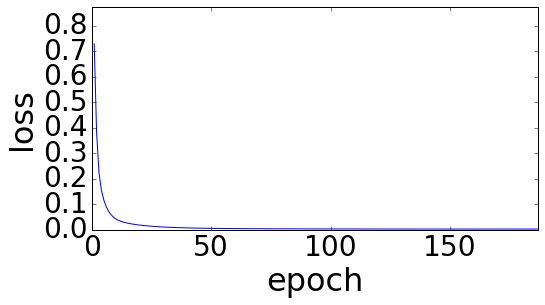

In [13]:
plotLoss(dnn)

### plot results

In [14]:
def plotResults(dnn, X_test, y_test, xmin=0, xmax=1, ymin=0, ymax=1, ftsize=FONTSIZE):
    p = dnn.predict(X_test)
    print p[:5]
    # set size of figure
    plt.figure(figsize=(8,8));

    # get axis info
    axes = plt.gca()
    # set axes' limits
    axes.set_xlim(xmin, xmax)
    axes.set_ylim(ymin, ymax)
    
    # annotate axes
    plt.xlabel(r'wine quality', fontsize=ftsize)
    plt.ylabel(r'predicted wine quality', fontsize=ftsize)
    
    # choose color of points
    blue= (0,0,1)
    plt.scatter(y_test, p, marker='o', s=50, c=blue, alpha=0.2)    
    plt.savefig('02_dnn_wine_results.png')
    plt.show()

[ 0.64636066  0.56709857  0.59029707  0.57681098  0.57120613]


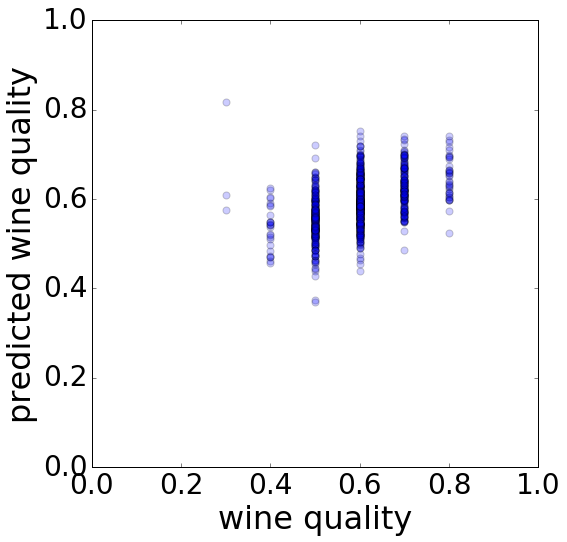

In [15]:
plotResults(dnn, X_test, y_test)